In [ ]:
import os
print(os.listdir("/content/drive/MyDrive/test"))

['Glaucoma', '0']


In [ ]:
from __future__ import print_function
import time
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm_notebook as tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH = '/content/drive/MyDrive/test/Glaucoma'
images = os.listdir(PATH)
print(f'There are {len(os.listdir(PATH))} of Glaucoma')


There are 429 of Glaucoma


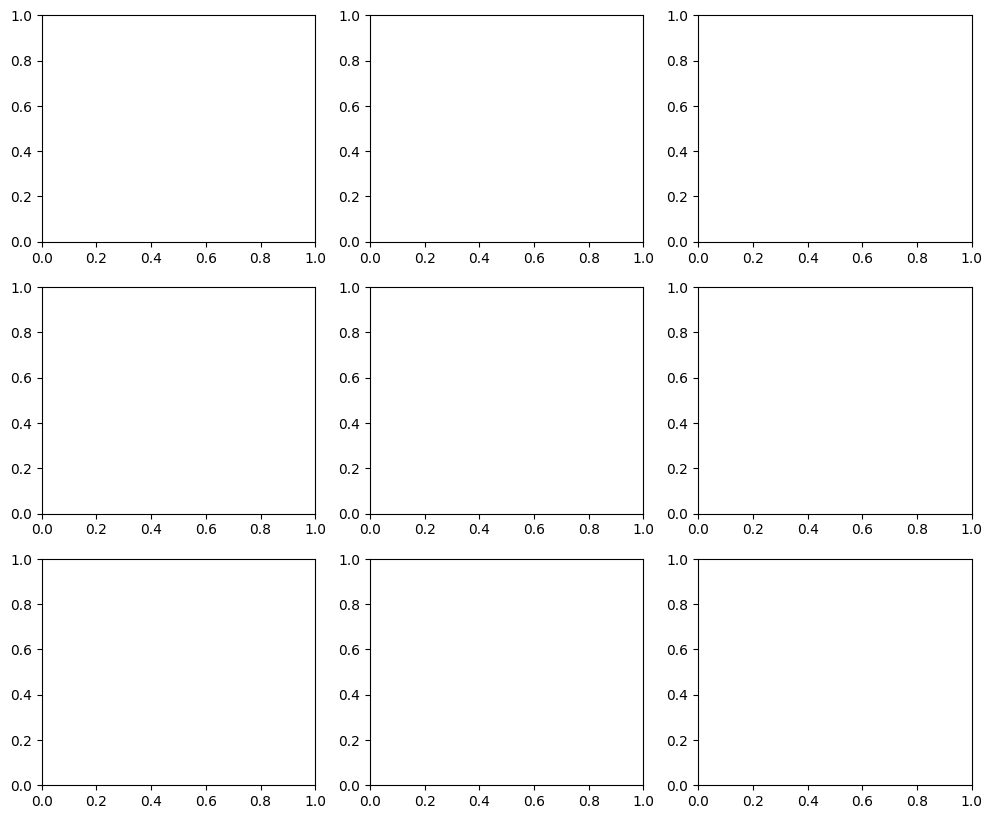

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,10))

for indx, axis in enumerate(axes.flatten()):
    rnd_indx = np.random.randint(0, len(os.listdir(PATH)))
  

In [ ]:
  # https://matplotlib.org/users/image_tutorial.html
img = plt.imread('/content/drive/MyDrive/test/Glaucoma/ORIGA-110.png')
imgplot = axis.imshow(img)
axis.set_title(images[rnd_indx])
axis.set_axis_off()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

<Figure size 640x480 with 0 Axes>

In [ ]:
batch_size = 32
batchSize = 64
imageSize = 64

# 64x64 images!
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder('/content/drive/MyDrive/test', transform=transform)

dataloader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)

imgs, label = next(iter(dataloader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

In [ ]:
batch_size = 32
image_size = 64

random_transforms = [transforms.ColorJitter(), transforms.RandomRotation(degrees=20)]
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomApply(random_transforms, p=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder('/content/drive/MyDrive/test', transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)
                                           
imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

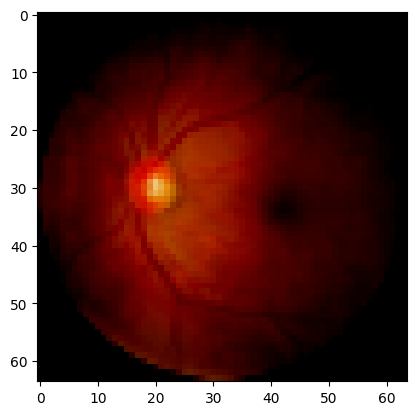

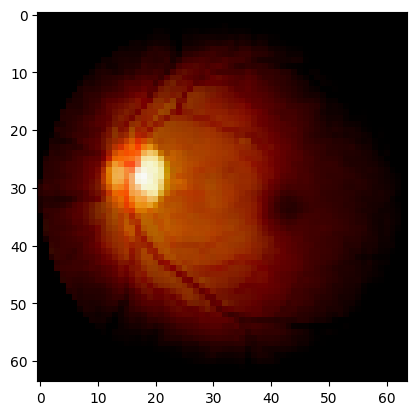

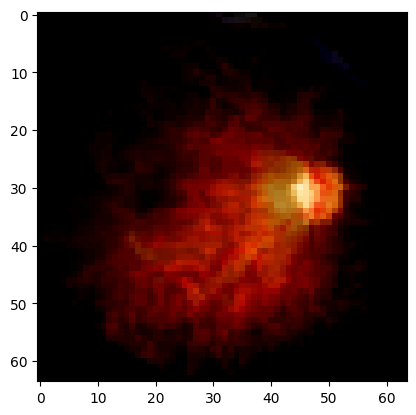

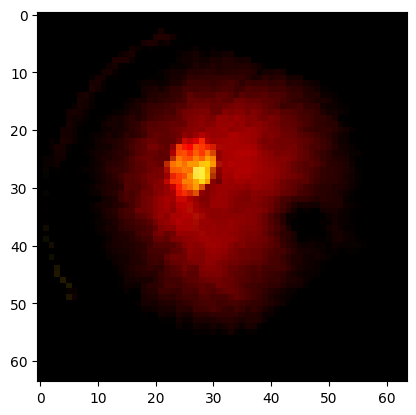

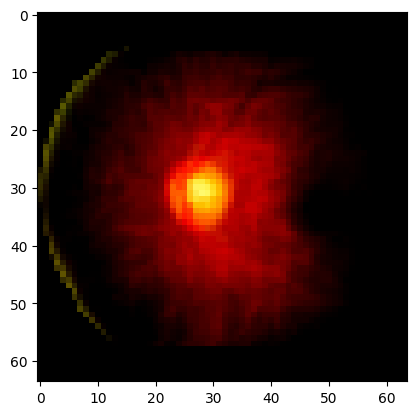

In [ ]:
for i in range(5):
    plt.imshow(imgs[i])
    plt.show()

In [ ]:
def weights_init(m):
    """
    Takes as input a neural network m that will initialize all its weights.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
class G(nn.Module):
    def __init__(self):
        # Used to inherit the torch.nn Module
        super(G, self).__init__()
        # Meta Module - consists of different layers of Modules
        self.main = nn.Sequential(
                nn.ConvTranspose2d(100, 512, 4, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(512),
                nn.ReLU(True),
                nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(True),
                nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(True),
                nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1, bias=False),
                nn.Tanh()
                )
        
    def forward(self, input):
        output = self.main(input)
        return output

# Creating the generator
netG = G()
netG.apply(weights_init)

G(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [ ]:
# Defining the discriminator
class D(nn.Module):
    def __init__(self):
        super(D, self).__init__()
        self.main = nn.Sequential(
                nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(512, 1, 4, stride=1, padding=0, bias=False),
                nn.Sigmoid()
                )
        
    def forward(self, input):
        output = self.main(input)
        # .view(-1) = Flattens the output into 1D instead of 2D
        return output.view(-1)
    
    
# Creating the discriminator
netD = D()
netD.apply(weights_init)

D(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [ ]:
!mkdir results
!ls

drive  results	sample_data


In [ ]:
EPOCH = 1 # play with me
LR = 0.001
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=LR, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(0.5, 0.999))

In [ ]:
batch_size = 32
LR_G = 0.001
LR_D = 0.0005

beta1 = 0.5
epochs = 100

real_label = 0.9
fake_label = 0
nz = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
EPOCH = 0 # play with me
LR = 0.001
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=LR, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(0.5, 0.999))

In [ ]:
for epoch in range(EPOCH):
    for i, data in enumerate(dataloader, 0):
        # 1st Step: Updating the weights of the neural network of the discriminator
        netD.zero_grad()
        
        # Training the discriminator with a real image of the dataset
        real,_ = data
        input = Variable(real)
        target = Variable(torch.ones(input.size()[0]))
        output = netD(input)
        errD_real = criterion(output, target)
        
        # Training the discriminator with a fake image generated by the generator
        noise = Variable(torch.randn(input.size()[0], 100, 1, 1))
        fake = netG(noise)
        target = Variable(torch.zeros(input.size()[0]))
        output = netD(fake.detach())
        errD_fake = criterion(output, target)
        
        # Backpropagating the total error
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()
        
        # 2nd Step: Updating the weights of the neural network of the generator
        netG.zero_grad()
        target = Variable(torch.ones(input.size()[0]))
        output = netD(fake)
        errG = criterion(output, target)
        errG.backward()
        optimizerG.step()
        
        # 3rd Step: Printing the losses and saving the real images and the generated images of the minibatch every 100 steps
        print('[%d/%d][%d/%d] Loss_D: %.4f; Loss_G: %.4f' % (epoch, EPOCH, i, len(dataloader), errD.item(), errG.item()))
        if i % 100 == 0:
            vutils.save_image(real, '%s/real_samples.png' % "./results", normalize=True)
            fake = netG(noise)
            vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d.png' % ("./results", epoch), normalize=True)

In [ ]:
batch_size = 32
LR_G = 0.001
LR_D = 0.0005

beta1 = 0.5
epochs = 100

real_label = 0.9
fake_label = 0
nz = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz=128, channels=3):
        super(Generator, self).__init__()
        
        self.nz = nz
        self.channels = channels
        
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block

        self.model = nn.Sequential(
            *convlayer(self.nz, 1024, 4, 1, 0), # Fully connected layer via convolution.
            *convlayer(1024, 512, 4, 2, 1),
            *convlayer(512, 256, 4, 2, 1),
            *convlayer(256, 128, 4, 2, 1),
            *convlayer(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(-1, self.nz, 1, 1)
        img = self.model(z)
        return img

    
class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()
        
        self.channels = channels

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        self.model = nn.Sequential(
            *convlayer(self.channels, 32, 4, 2, 1),
            *convlayer(32, 64, 4, 2, 1),
            *convlayer(64, 128, 4, 2, 1, bn=True),
            *convlayer(128, 256, 4, 2, 1, bn=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # FC with Conv.
        )

    def forward(self, imgs):
        logits = self.model(imgs)
        out = torch.sigmoid(logits)
    
        return out.view(-1, 1)

In [ ]:
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=LR_D, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR_G, betas=(beta1, 0.999))

fixed_noise = torch.randn(25, nz, 1, 1, device=device)

G_losses = []
D_losses = []
epoch_time = []

In [ ]:
def plot_loss (G_losses, D_losses, epoch):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss - EPOCH "+ str(epoch))
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [ ]:
def show_generated_img(n_images=5):
    sample = []
    for _ in range(n_images):
        noise = torch.randn(1, nz, 1, 1, device=device)
        gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
        gen_image = gen_image.numpy().transpose(1, 2, 0)
        sample.append(gen_image)
    
    figure, axes = plt.subplots(1, len(sample), figsize = (64,64))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample[index]
        axis.imshow(image_array)
        
    plt.show()
    plt.close()

<ipython-input-29-a6affce909ef>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ii, (real_images, train_labels) in tqdm(enumerate(train_loader), total=len(train_loader)):


  0%|          | 0/113 [00:00<?, ?it/s]

[1/100][56/113] Loss_D: 1.3017 Loss_G: 0.9566 D(x): 0.3953 D(G(z)): 0.3169 / 0.3767
[1/100][112/113] Loss_D: 1.4777 Loss_G: 0.9321 D(x): 0.4069 D(G(z)): 0.4124 / 0.3838


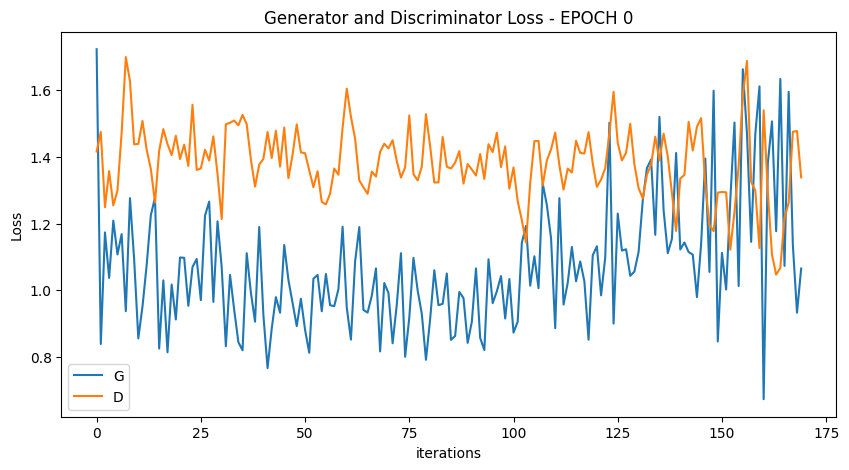

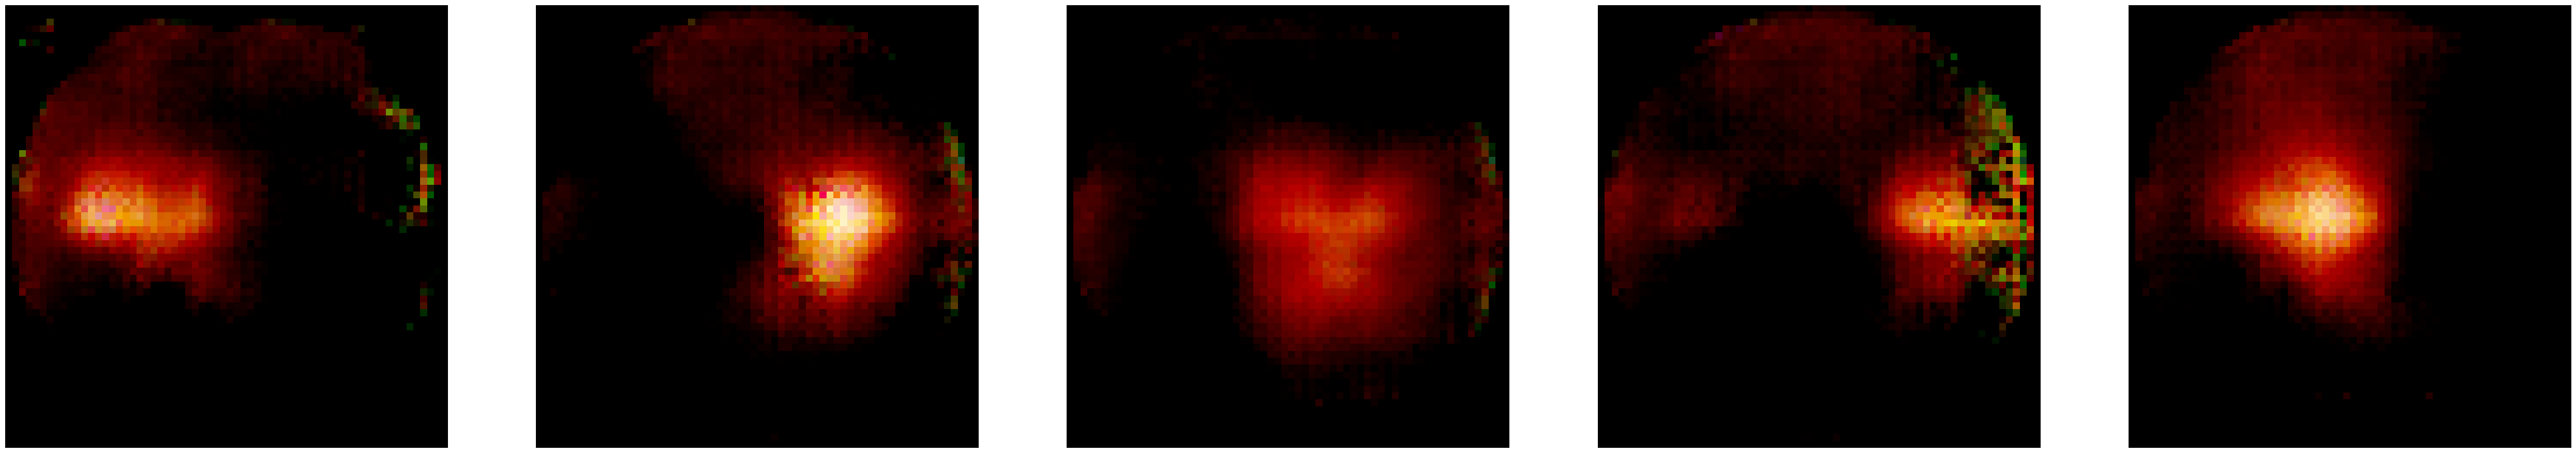

  0%|          | 0/113 [00:00<?, ?it/s]

[2/100][56/113] Loss_D: 1.2698 Loss_G: 1.3191 D(x): 0.5602 D(G(z)): 0.4687 / 0.2451
[2/100][112/113] Loss_D: 1.2441 Loss_G: 1.1590 D(x): 0.5083 D(G(z)): 0.4105 / 0.3089


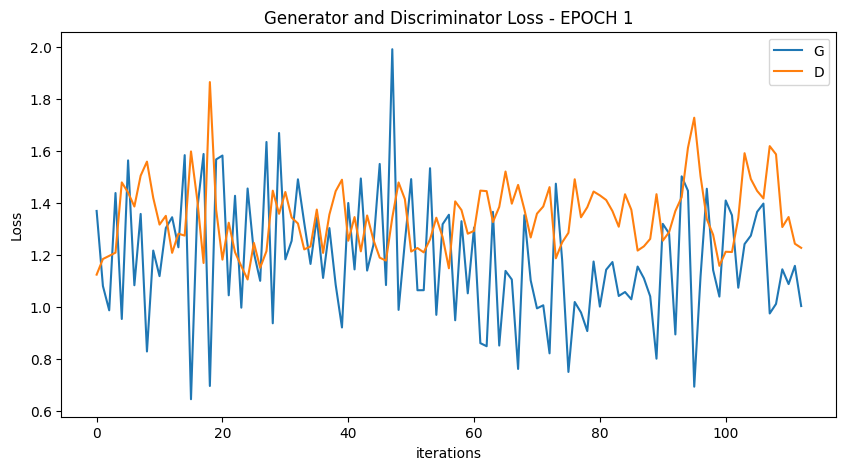

  0%|          | 0/113 [00:00<?, ?it/s]

[3/100][56/113] Loss_D: 1.3874 Loss_G: 0.9598 D(x): 0.4995 D(G(z)): 0.4624 / 0.3769
[3/100][112/113] Loss_D: 1.4042 Loss_G: 0.9402 D(x): 0.4590 D(G(z)): 0.4539 / 0.3777


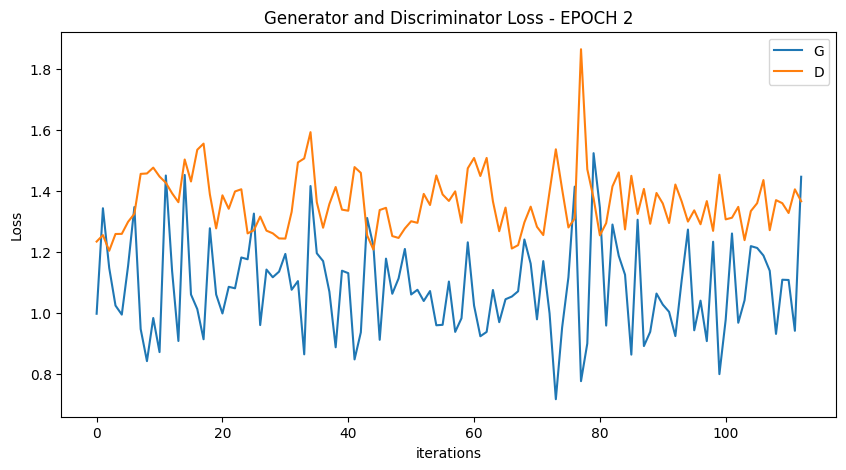

  0%|          | 0/113 [00:00<?, ?it/s]

[4/100][56/113] Loss_D: 1.1799 Loss_G: 1.2221 D(x): 0.4113 D(G(z)): 0.2684 / 0.2760
[4/100][112/113] Loss_D: 1.3368 Loss_G: 0.9553 D(x): 0.4352 D(G(z)): 0.3932 / 0.3711


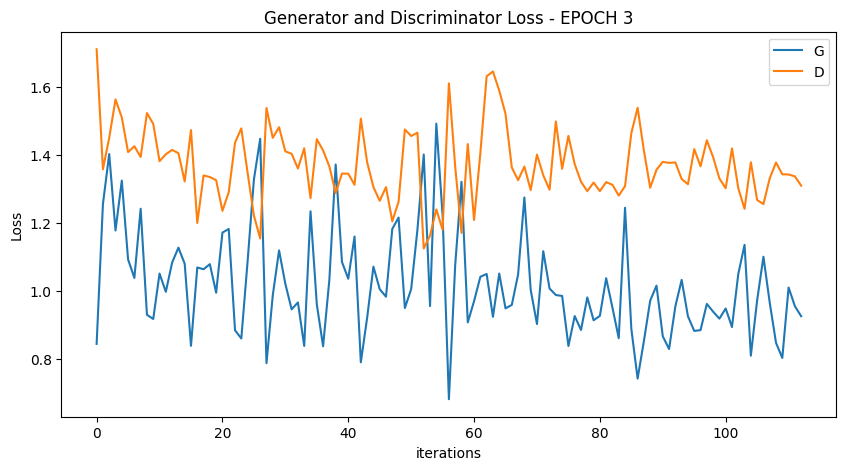

  0%|          | 0/113 [00:00<?, ?it/s]

[5/100][56/113] Loss_D: 1.3763 Loss_G: 0.9476 D(x): 0.4023 D(G(z)): 0.3771 / 0.3739
[5/100][112/113] Loss_D: 1.2622 Loss_G: 1.0259 D(x): 0.4709 D(G(z)): 0.3833 / 0.3478


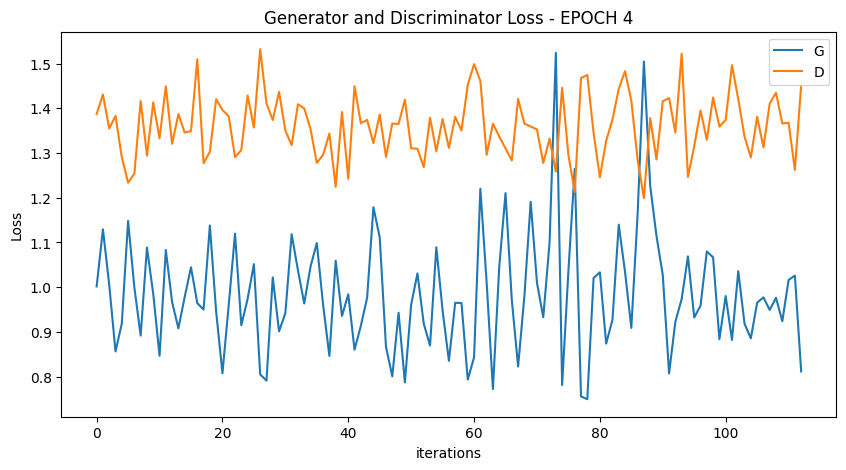

  0%|          | 0/113 [00:00<?, ?it/s]

[6/100][56/113] Loss_D: 1.4110 Loss_G: 0.9770 D(x): 0.4070 D(G(z)): 0.3916 / 0.3644
[6/100][112/113] Loss_D: 1.3599 Loss_G: 1.0935 D(x): 0.4845 D(G(z)): 0.4402 / 0.3163


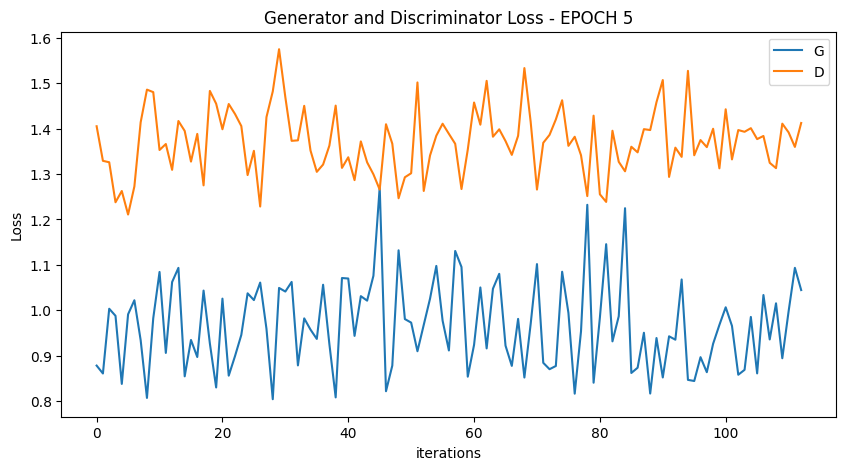

  0%|          | 0/113 [00:00<?, ?it/s]

[7/100][56/113] Loss_D: 1.3150 Loss_G: 0.9843 D(x): 0.4466 D(G(z)): 0.3932 / 0.3595
[7/100][112/113] Loss_D: 1.3976 Loss_G: 0.9441 D(x): 0.4688 D(G(z)): 0.4676 / 0.3787


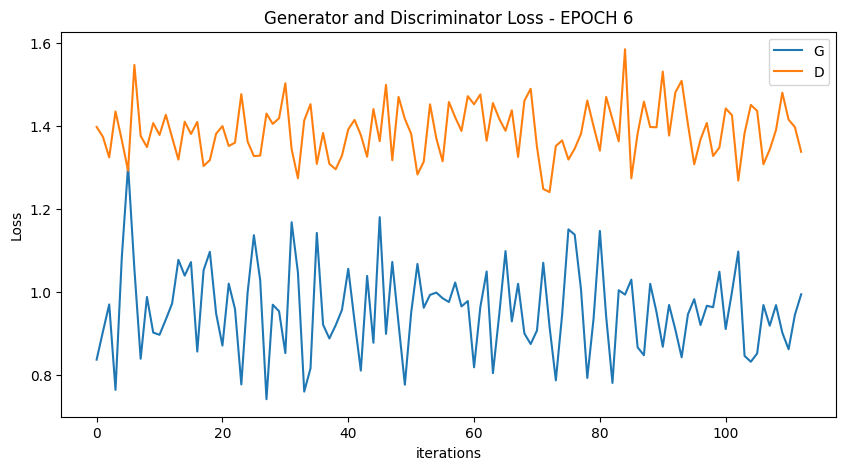

  0%|          | 0/113 [00:00<?, ?it/s]

[8/100][56/113] Loss_D: 1.3796 Loss_G: 0.9269 D(x): 0.4381 D(G(z)): 0.4292 / 0.3827
[8/100][112/113] Loss_D: 1.3477 Loss_G: 0.9414 D(x): 0.5036 D(G(z)): 0.4731 / 0.3781


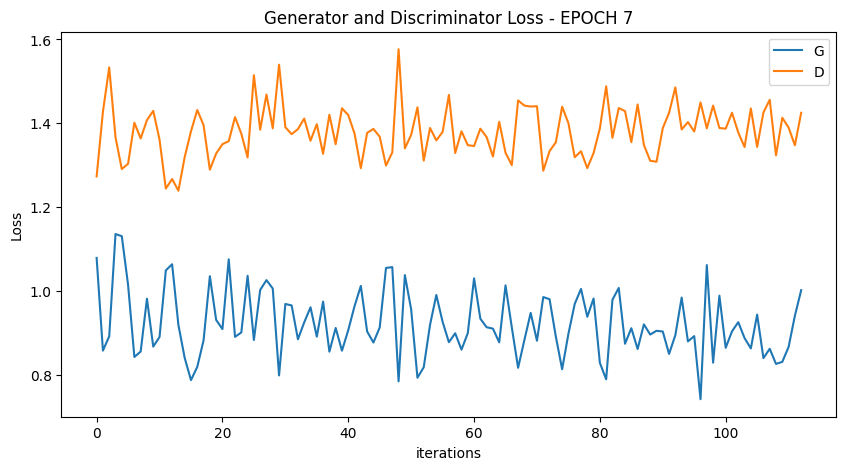

  0%|          | 0/113 [00:00<?, ?it/s]

[9/100][56/113] Loss_D: 1.4474 Loss_G: 0.9061 D(x): 0.4209 D(G(z)): 0.4431 / 0.3903
[9/100][112/113] Loss_D: 1.3367 Loss_G: 1.0436 D(x): 0.4951 D(G(z)): 0.4576 / 0.3358


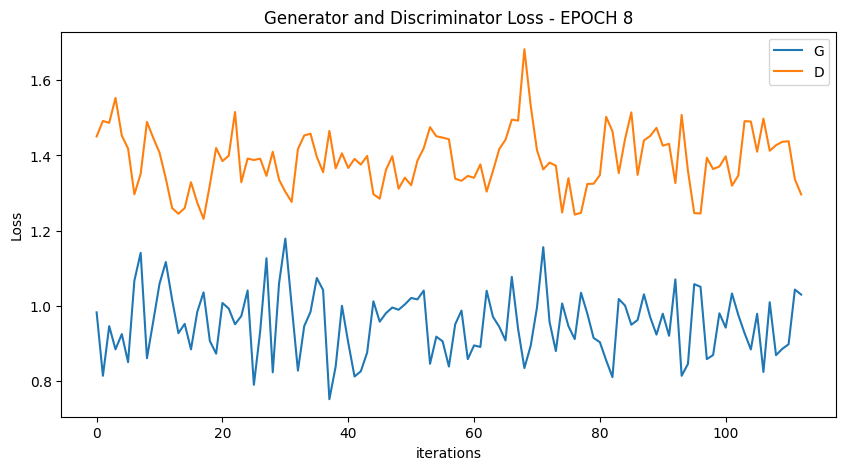

  0%|          | 0/113 [00:00<?, ?it/s]

[10/100][56/113] Loss_D: 1.3280 Loss_G: 0.9550 D(x): 0.3943 D(G(z)): 0.3371 / 0.3701
[10/100][112/113] Loss_D: 1.4215 Loss_G: 0.8703 D(x): 0.4160 D(G(z)): 0.4206 / 0.4093


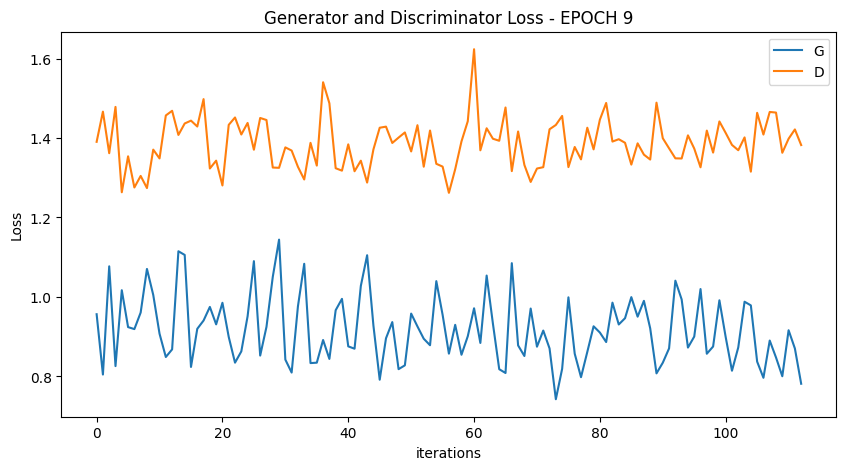

  0%|          | 0/113 [00:00<?, ?it/s]

[11/100][56/113] Loss_D: 1.3792 Loss_G: 0.9256 D(x): 0.4298 D(G(z)): 0.4221 / 0.3824
[11/100][112/113] Loss_D: 1.4278 Loss_G: 0.9424 D(x): 0.4771 D(G(z)): 0.4854 / 0.3800


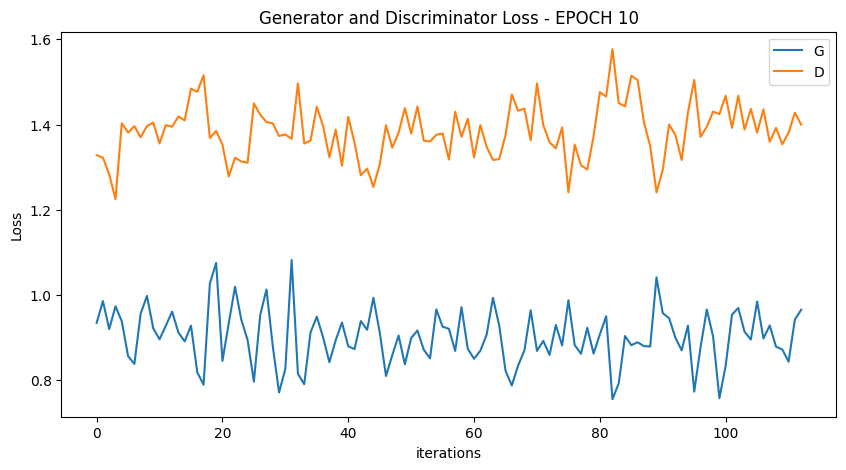

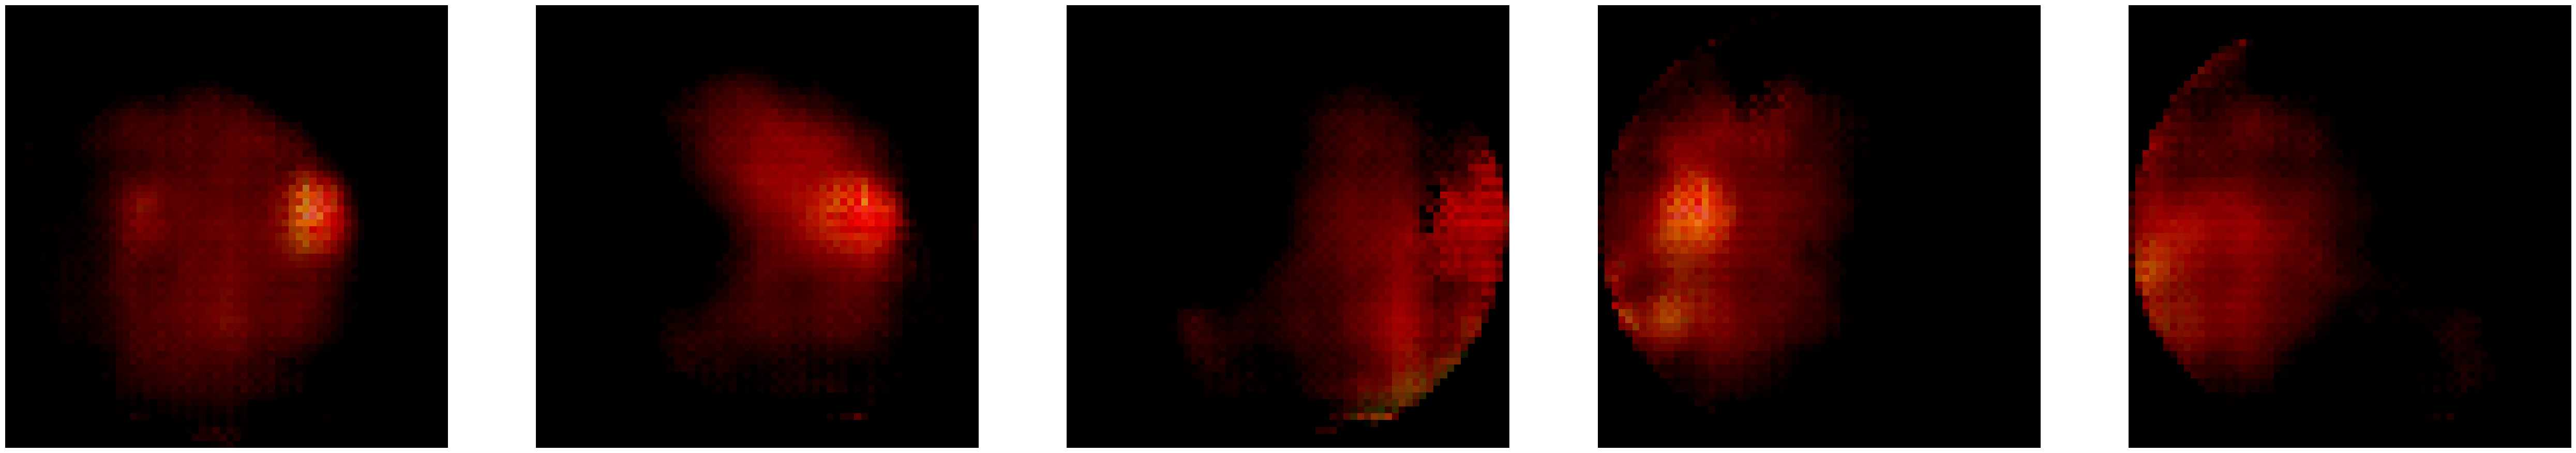

  0%|          | 0/113 [00:00<?, ?it/s]

[12/100][56/113] Loss_D: 1.4498 Loss_G: 0.7976 D(x): 0.4388 D(G(z)): 0.4627 / 0.4479
[12/100][112/113] Loss_D: 1.3964 Loss_G: 0.8793 D(x): 0.4592 D(G(z)): 0.4537 / 0.4070


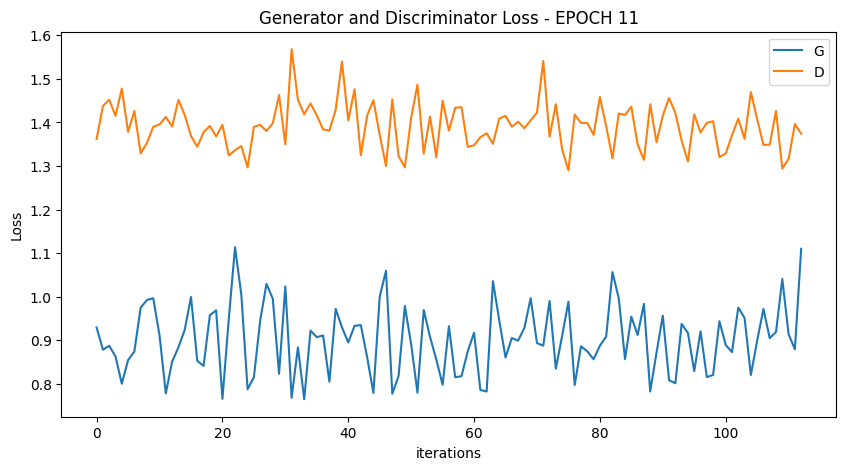

  0%|          | 0/113 [00:00<?, ?it/s]

[13/100][56/113] Loss_D: 1.4190 Loss_G: 0.8998 D(x): 0.4285 D(G(z)): 0.4318 / 0.3954
[13/100][112/113] Loss_D: 1.4699 Loss_G: 0.7844 D(x): 0.4281 D(G(z)): 0.4601 / 0.4517


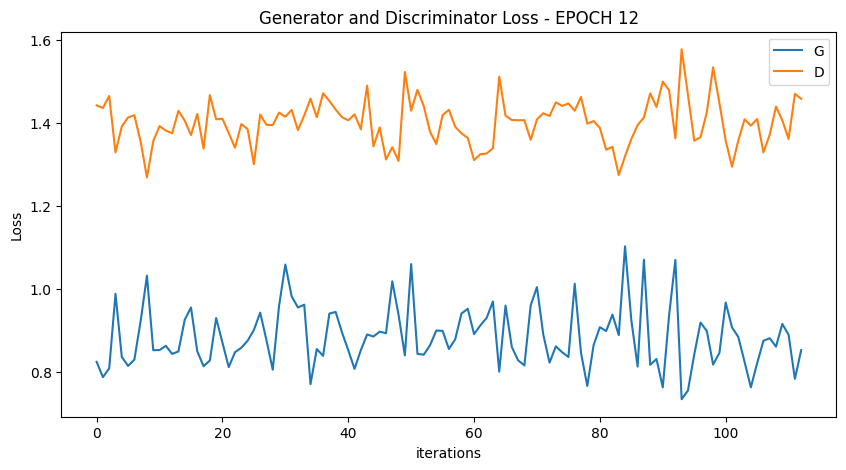

  0%|          | 0/113 [00:00<?, ?it/s]

[14/100][56/113] Loss_D: 1.4113 Loss_G: 0.9727 D(x): 0.4532 D(G(z)): 0.4638 / 0.3602
[14/100][112/113] Loss_D: 1.3467 Loss_G: 0.8269 D(x): 0.4593 D(G(z)): 0.4331 / 0.4290


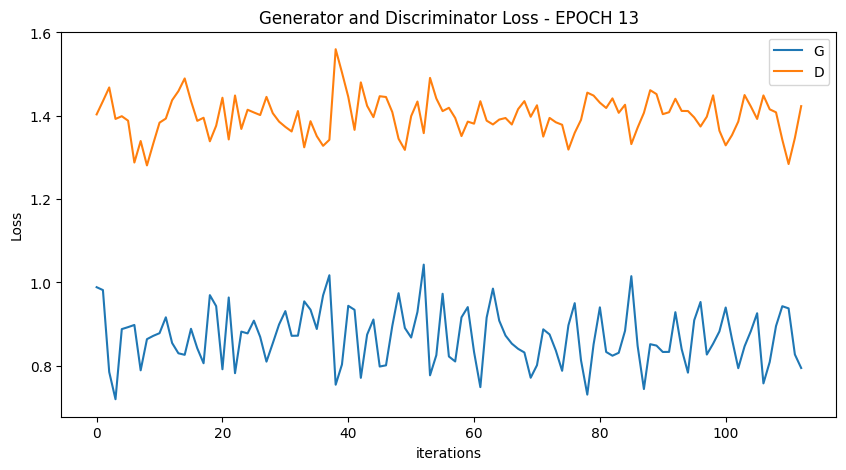

  0%|          | 0/113 [00:00<?, ?it/s]

[15/100][56/113] Loss_D: 1.3663 Loss_G: 0.8566 D(x): 0.4392 D(G(z)): 0.4237 / 0.4130
[15/100][112/113] Loss_D: 1.4936 Loss_G: 0.8151 D(x): 0.3717 D(G(z)): 0.4113 / 0.4364


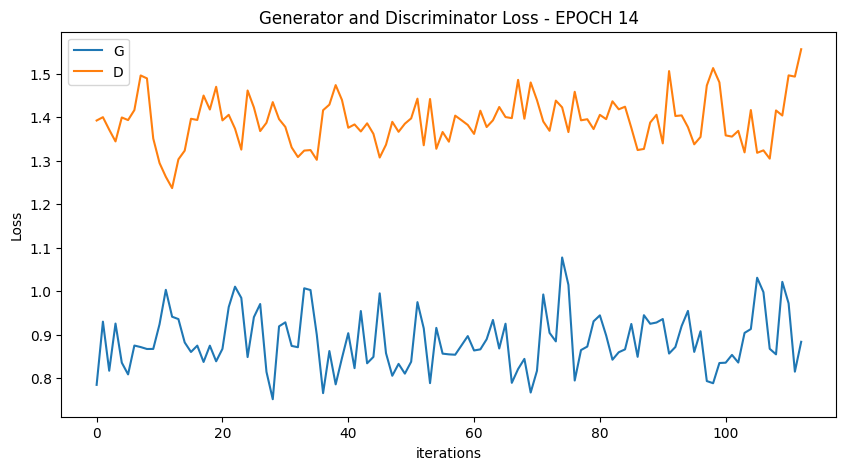

  0%|          | 0/113 [00:00<?, ?it/s]

[16/100][56/113] Loss_D: 1.4394 Loss_G: 0.8457 D(x): 0.3841 D(G(z)): 0.3918 / 0.4183
[16/100][112/113] Loss_D: 1.3241 Loss_G: 0.8433 D(x): 0.4905 D(G(z)): 0.4478 / 0.4211


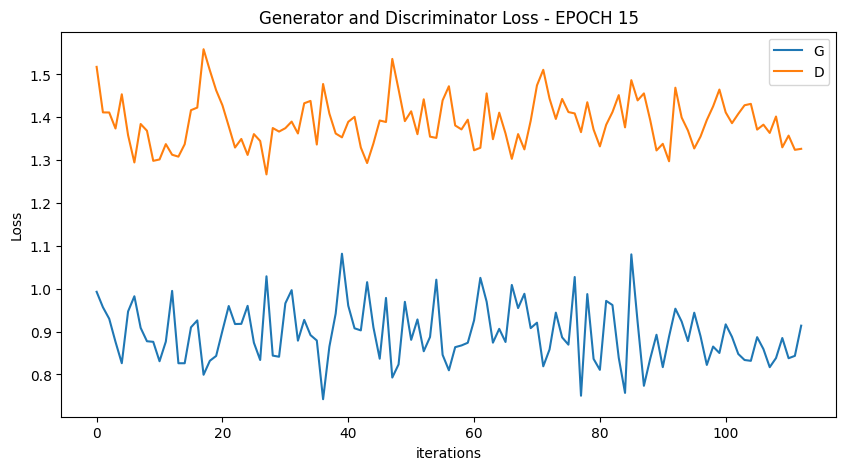

  0%|          | 0/113 [00:00<?, ?it/s]

[17/100][56/113] Loss_D: 1.4301 Loss_G: 1.0261 D(x): 0.4000 D(G(z)): 0.4089 / 0.3414
[17/100][112/113] Loss_D: 1.3764 Loss_G: 0.8235 D(x): 0.4559 D(G(z)): 0.4430 / 0.4323


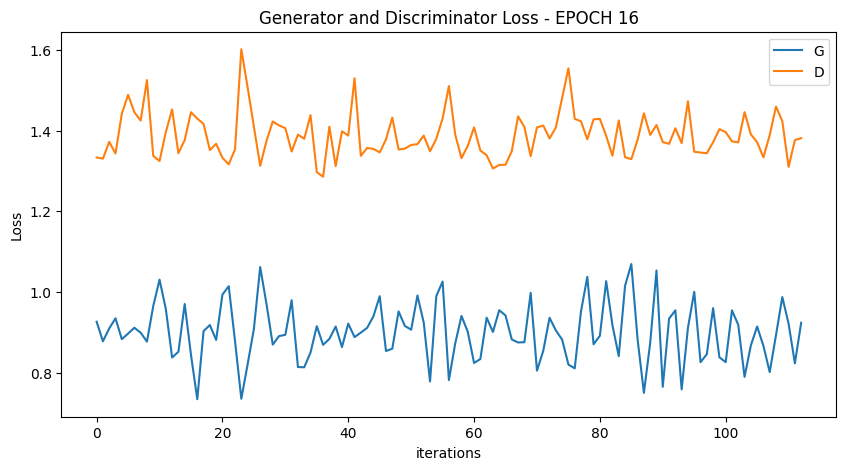

  0%|          | 0/113 [00:00<?, ?it/s]

[18/100][56/113] Loss_D: 1.3774 Loss_G: 0.8381 D(x): 0.4402 D(G(z)): 0.4322 / 0.4210
[18/100][112/113] Loss_D: 1.3026 Loss_G: 0.9884 D(x): 0.4815 D(G(z)): 0.4283 / 0.3591


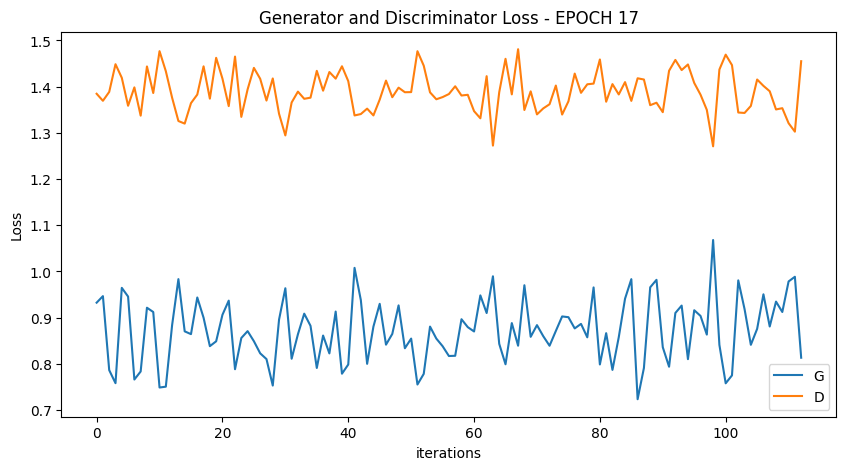

  0%|          | 0/113 [00:00<?, ?it/s]

[19/100][56/113] Loss_D: 1.4065 Loss_G: 0.8633 D(x): 0.4558 D(G(z)): 0.4664 / 0.4085
[19/100][112/113] Loss_D: 1.3965 Loss_G: 0.7898 D(x): 0.4198 D(G(z)): 0.4189 / 0.4473


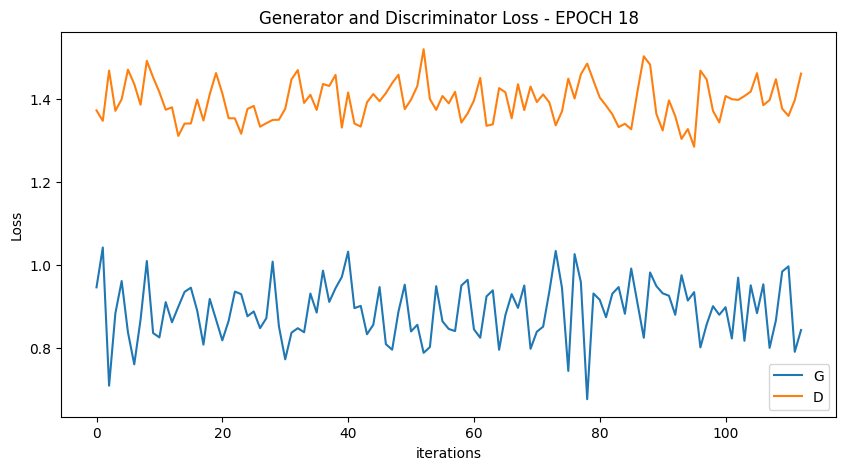

  0%|          | 0/113 [00:00<?, ?it/s]

[20/100][56/113] Loss_D: 1.3630 Loss_G: 1.0046 D(x): 0.4668 D(G(z)): 0.4503 / 0.3499
[20/100][112/113] Loss_D: 1.3651 Loss_G: 0.9673 D(x): 0.4560 D(G(z)): 0.4364 / 0.3647


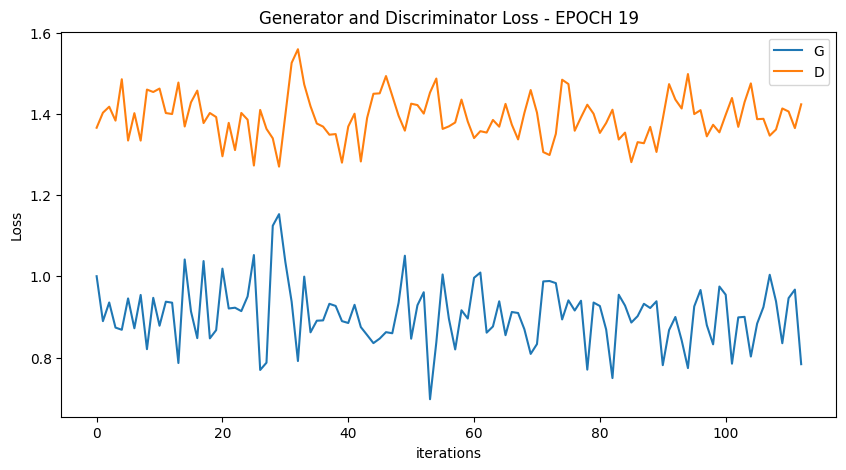

  0%|          | 0/113 [00:00<?, ?it/s]

In [ ]:
for epoch in range(epochs):
    
    start = time.time()
    for ii, (real_images, train_labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)

        output = netD(real_images)
        errD_real = criterion(output, labels)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labels.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labels)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        if (ii+1) % (len(train_loader)//2) == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch + 1, epochs, ii+1, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
    plot_loss (G_losses, D_losses, epoch)
    G_losses = []
    D_losses = []
    if epoch % 10 == 0:
        show_generated_img()

    epoch_time.append(time.time()- start)
    
#             valid_image = netG(fixed_noise)

In [ ]:
if not os.path.exists('/content/drive/MyDrive/Output Gan Images'):
    os.mkdir('/content/drive/MyDrive/Output Gan Images')
    
im_batch_size = 100
n_images= 3000

for i_batch in tqdm(range(0, n_images, im_batch_size)):
    gen_z = torch.randn(im_batch_size, nz, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('/content/drive/MyDrive/Output Gan Images', f'image_{i_batch+i_image:05d}.png'))

<ipython-input-28-265f847928b8>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i_batch in tqdm(range(0, n_images, im_batch_size)):


  0%|          | 0/27 [00:00<?, ?it/s]

In [ ]:
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for i, j in enumerate(images[:32]):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    plt.imshow(j)